In [15]:
import matplotlib.pyplot as plt
import numpy as np
import utils

In [16]:
def rectify(image_path, points_path, output_path):
    img = plt.imread(image_path)

    if img is None:
        print("Error: The image could not be loaded.")
        exit()

    points1, points2  = utils.load_points(img, img, points_path)

    points1 = np.array(points1)
    points2 = np.array(points2)

    H = utils.computeH(points1, points2)

    img_warped, _, _ = utils.warpImage(img, H, True)

    plt.imshow(img_warped)
    plt.axis('off')
    plt.show()

    plt.imsave(output_path, img_warped.astype(np.uint8))

In [31]:
def do_everything(image1_path, image2_path, points_path, output_path):
    img1 = plt.imread(image1_path)
    img2 = plt.imread(image2_path)

    if img1 is None or img2 is None:
        print("Error: One of the images could not be loaded.")
        exit()

    points_img1, points_img2 = utils.load_points(img1, img2, points_path)

    points_img1 = np.array(points_img1)
    points_img2 = np.array(points_img2)

    H = utils.computeH(points_img1, points_img2)
    print(H)

    img1_warped, alpha, translate = utils.warpImage(img1, H)

    combined_images = utils.combine_images(img1_warped / 255.0, img2 / 255.0, alpha, translate)

    plt.imshow(combined_images)
    plt.axis('off')
    plt.show()

    plt.imsave(output_path, combined_images)


In [18]:
def create_panorama(image_path1, image_path2, output_path):
    print(f"Processing {image_path1} and {image_path2}")
    
    print("Reading images")
    image1 = plt.imread(image_path1)
    image2 = plt.imread(image_path2)
    
    print("Converting images to grayscale for corner detection")
    image1_gray = np.mean(image1, axis=2)
    image2_gray = np.mean(image2, axis=2)

    print("Getting Harris corners for image 1")
    h1, coords1 = utils.get_harris_corners(image1_gray)
    print("Getting Harris corners for image 2")
    h2, coords2 = utils.get_harris_corners(image2_gray)

    print("Displaying Harris corners on original images")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.scatter(coords1[:, 1], coords1[:, 0], color='red', s=2)
    plt.title("Image 1 Harris Corners")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.scatter(coords2[:, 1], coords2[:, 0], color='red', s=2)
    plt.title("Image 2 Harris Corners")
    plt.axis('off')
    plt.show()

    print("Applying ANMS on image 1")
    coords1 = utils.anms(h1, coords1)
    print("Applying ANMS on image 2")
    coords2 = utils.anms(h2, coords2)

    print("Displaying ANMS corners")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.scatter(coords1[:, 1], coords1[:, 0], color='blue', s=3)
    plt.title("Image 1 ANMS Corners")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.scatter(coords2[:, 1], coords2[:, 0], color='blue', s=3)
    plt.title("Image 2 ANMS Corners")
    plt.axis('off')
    plt.show()

    print("Getting features for image 1")
    gaussian_stack1 = utils.get_gaussian_stack(image1_gray, 3, 2)
    features1 = utils.get_features(coords1, gaussian_stack1)
    
    print("Getting features for image 2")
    gaussian_stack2 = utils.get_gaussian_stack(image2_gray, 3, 2)
    features2 = utils.get_features(coords2, gaussian_stack2)

    print("Matching features between images")
    comparison_map, feature_pairs = utils.compare_features(features1, features2)

    print("Visualizing feature pairs")
    utils.visualize_feature_pairs(image1, image2, coords1, coords2, feature_pairs)

    print("Running RANSAC to compute homography")
    H, _, c, d = utils.RANSAC(feature_pairs, comparison_map, coords1, coords2, 3000, 3)
    print(f"Found homography matrix:\n{H}\n with {c} inliers and {d} distance")

    print("Adjusting homography matrix for [x, y, 1] input")
    H_adjusted = H[[1, 0, 2], :][:, [1, 0, 2]]

    print("Warping image 1")
    warped_image, alpha, translate = utils.warpImage(image1, H_adjusted)

    print("Combining images into a panorama")
    combined_image = utils.combine_images(warped_image / 255.0, image2 / 255.0, alpha, translate)

    print("Displaying combined image")
    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()

    print(f"Saving combined image to {output_path}")
    plt.imsave(output_path, combined_image)

    return combined_image

Loaded points from file:
Points from Image 1: [[335.21624039226083, 335.9271799628942], [429.18313510469125, 311.6883696660482], [420.88217267426455, 468.0785018552875], [327.5793549562683, 479.0357722634508]]
Points from Image 2: [[3.753826530612514, 3.9464285714284415], [678.1288265306123, 5.428571428571331], [679.6109693877552, 903.6071428571428], [5.235969387755404, 903.6071428571428]]
Output image dimensions: width=685, height=913
Translation offsets: translate_x=0, translate_y=0
Starting inverse mapping of pixels...


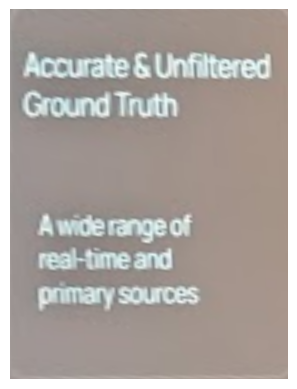

In [25]:
rectify("data/x.jpg", "data/selected_points_x.json", "output/x_rectified.jpg")

In [20]:
rectify("data/chinese_food.jpg", "data/chinese_points.json", "output/chinese_rectified.jpg")

Loaded points from file:
Points from Image 1: [[695.0130911966702, 542.9819289906352], [623.7006870548806, 2478.566275659824], [1944.6635023041479, 1298.333548387097]]
Points from Image 2: [[693.4596853277831, 543.348067596254], [623.6841281997915, 2479.042039708637]]


IndexError: index 2 is out of bounds for axis 0 with size 2

Loaded points from file:
Points from Image 1: [[406.0790875904789, 310.8042968251943], [479.9950542906278, 358.9060995823523], [707.1749226212505, 596.9482418686227], [447.0841783502989, 524.8842970117827], [720.0007884058773, 848.8270815231226]]
Points from Image 2: [[94.3197922557726, 284.6730059117497], [172.16195693267878, 347.01413346684774], [370.2657549597256, 594.896817831118], [122.1597489672101, 515.707065334009], [364.0014980459443, 826.0251507963944]]
[[ 1.56039338e+00 -1.16951993e-01 -4.75406146e+02]
 [ 4.61449238e-01  1.36259716e+00 -2.43140791e+02]
 [ 7.47423633e-04 -3.55142617e-05  1.00000000e+00]]
Output image dimensions: width=1065, height=1415
Translation offsets: translate_x=615.177303960406, translate_y=243.1407908085054
Starting inverse mapping of pixels...


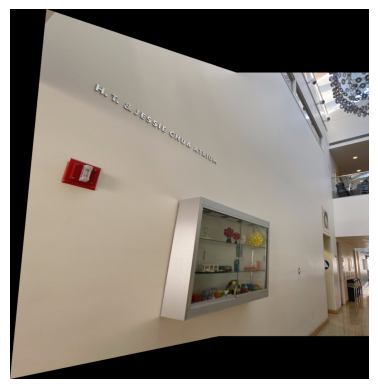

In [32]:
do_everything("data/soda-1.jpg", "data/soda-2.jpg", "data/selected_points.json", "output/soda.jpg")

Loaded points from file:
Points from Image 1: [[586.4530505723205, 305.06422393340284], [622.401204578564, 365.5417065556713], [728.1310693028096, 352.00828387096783], [603.7833012149142, 129.2224633431087], [656.886996229577, 126.65706744868055], [630.9764976958527, 119.21741935483891], [833.8981912174818, 316.18121573361094], [976.9295522164412, 304.88926618106154], [848.3267934235171, 217.69032241415204], [1036.5259526326743, 316.8085462643081]]
Points from Image 2: [[221.26047950052026, 375.7584840790844], [255.1645227887617, 439.44310593132167], [371.0796978147763, 426.6145490114465], [254.68902387934642, 196.4421700879767], [311.07072475911184, 202.43442815249284], [284.3779388353581, 190.7222873900295], [470.193893860562, 403.76305265348617], [594.5322147762749, 402.49429427679524], [489.22526951092624, 313.04682872008345], [641.47627471384, 414.5474988553592]]
Output image dimensions: width=1469, height=1035
Translation offsets: translate_x=784.2470785326279, translate_y=111.92

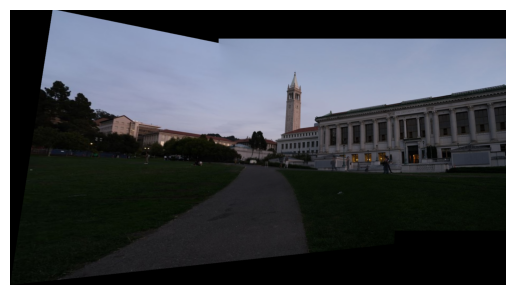

In [ ]:
do_everything("data/glade-1.jpg", "data/glade-2.jpg", "data/glade_points.json", "output/glade.jpg")

Loaded points from file:
Points from Image 1: [[502.519145723205, 286.18061835587946], [591.1278210197711, 423.1644828303851], [518.7957549219562, 559.5872238085327], [261.8067318210198, 456.22470110301776], [688.0511432258065, 413.7739086784601], [134.57493694068677, 282.7333212903227]]
Points from Image 2: [[809.5228182310093, 151.68316786680546], [914.2709056399581, 291.7973915504684], [843.1061475962542, 435.63632732570255], [578.3409446826222, 342.28214326742983], [1033.1153013943808, 274.529942476587], [456.399670842872, 186.03681481789815]]
Output image dimensions: width=1613, height=968
Translation offsets: translate_x=-326.01808416423677, translate_y=331.3319294782043
Starting forward mapping of pixels...
Number of points to interpolate: 777600
Interpolating pixel values...


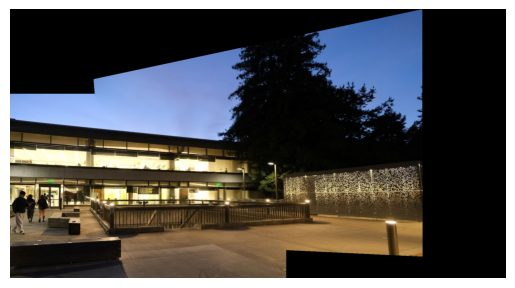

In [ ]:
do_everything("data/moffit-1.jpg", "data/moffit-2.jpg", "data/moffit_points.json", "output/moffit.jpg")

Loaded points from file:
Points from Image 1: [[564.95086867846, 82.3354530697192], [973.5794637620445, 44.672082111437135], [575.5306520707596, 417.8905764828305], [968.7599062643083, 409.9427115088449], [761.6590163579606, 256.1493089698232], [765.520673798127, 455.45413177939656]]
Points from Image 2: [[90.38452861602491, 9.325265348595252], [511.62925848345196, 72.54621700879787], [86.82092869927158, 393.10598576482835], [489.64164378772114, 400.1760411238294], [308.92715204994795, 237.21585931321556], [302.53301261186266, 439.37891279916767]]
[[ 2.20415306e+00 -8.37586693e-02 -1.09202499e+03]
 [ 4.98972827e-01  1.85725843e+00 -4.20159302e+02]
 [ 1.08038228e-03  3.15591056e-05  1.00000000e+00]]
Output image dimensions: width=1721, height=1316
Translation offsets: translate_x=1126.6819340424086, translate_y=420.15930219792716
Starting forward mapping of pixels...
Number of points to interpolate: 777600
Interpolating pixel values...


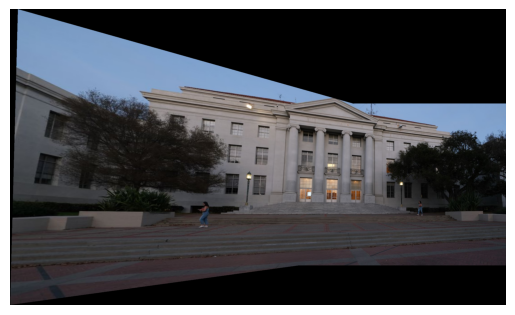

In [ ]:
do_everything("data/sproul-1.jpg", "data/sproul-2.jpg", "data/sproul_points.json", "output/sproul.jpg")

Processing data/soda-1.jpg and data/soda-2.jpg
Reading images
Converting images to grayscale for corner detection
Getting Harris corners for image 1
Getting Harris corners for image 2
Displaying Harris corners on original images


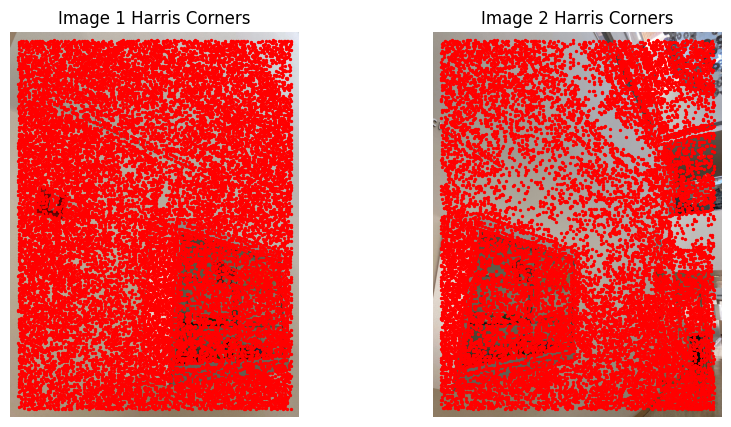

Applying ANMS on image 1


ANMS: 100%|██████████| 17210/17210 [00:02<00:00, 6094.90it/s]


Applying ANMS on image 2


ANMS: 100%|██████████| 13503/13503 [00:01<00:00, 8578.17it/s] 


Displaying ANMS corners


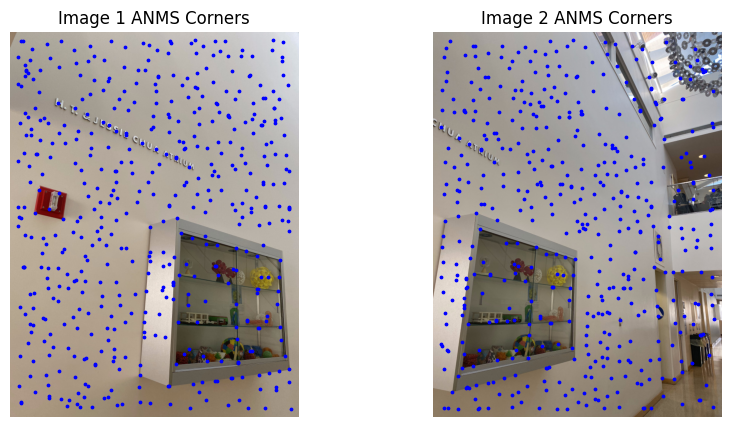

Getting features for image 1
Getting features for image 2
Matching features between images
Visualizing feature pairs


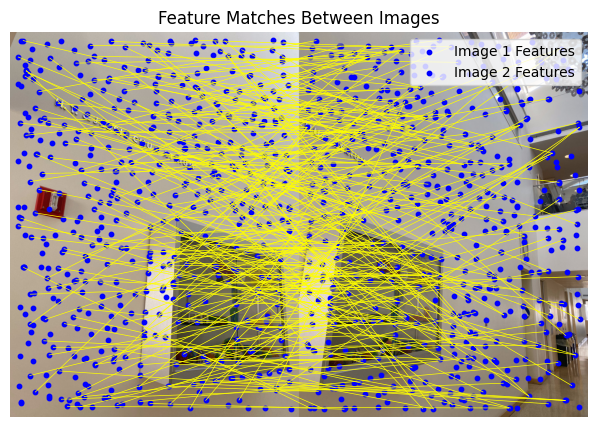

Running RANSAC to compute homography
(500, 2)


RANSAC: 100%|██████████| 3000/3000 [00:20<00:00, 143.36it/s]


Adjusting homography matrix for [x, y, 1] input
Warping image 1
Output image dimensions: width=1018, height=1340
Translation offsets: translate_x=564.2588096357533, translate_y=209.1466861347199
Starting inverse mapping of pixels...
Combining images into a panorama
Displaying combined image


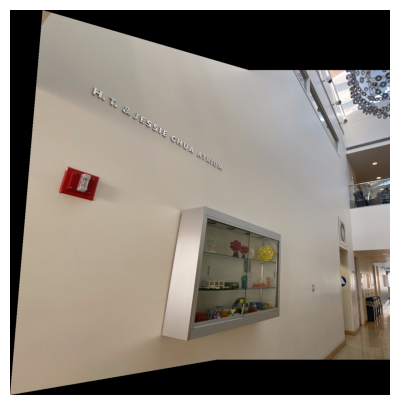

Saving combined image to output/soda.jpg


In [7]:
# Soda
_ = create_panorama("data/soda-1.jpg", "data/soda-2.jpg", "output/soda.jpg")

Processing data/glade-1.jpg and data/glade-2.jpg
Reading images
Converting images to grayscale for corner detection
Getting Harris corners for image 1
Getting Harris corners for image 2
Displaying Harris corners on original images


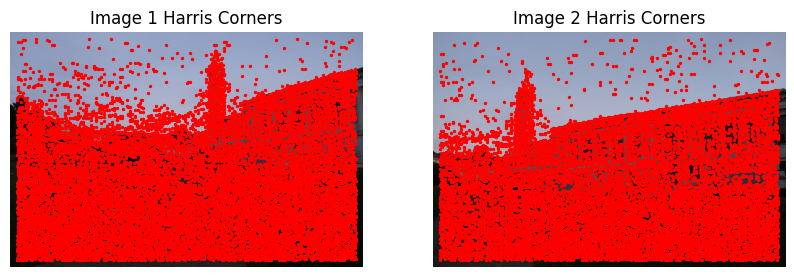

Applying ANMS on image 1


ANMS: 100%|██████████| 13359/13359 [00:01<00:00, 9347.28it/s] 


Applying ANMS on image 2


ANMS: 100%|██████████| 11739/11739 [00:01<00:00, 9117.97it/s] 


Displaying ANMS corners


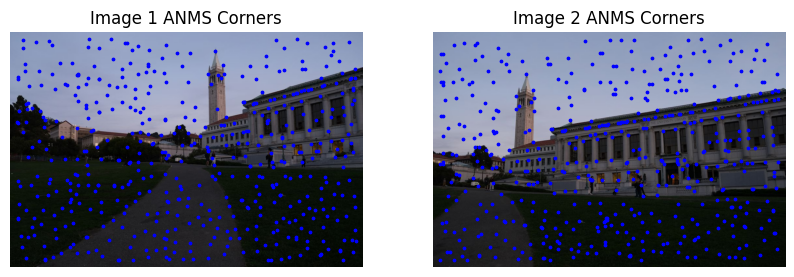

Getting features for image 1
Getting features for image 2
Matching features between images
Visualizing feature pairs


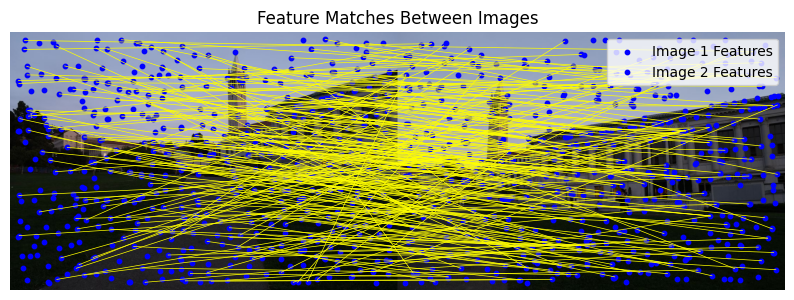

Running RANSAC to compute homography
(500, 2)


RANSAC: 100%|██████████| 3000/3000 [00:27<00:00, 109.69it/s]


Adjusting homography matrix for [x, y, 1] input
Warping image 1
Output image dimensions: width=1406, height=991
Translation offsets: translate_x=727.8547334954508, translate_y=79.15815309560509
Starting inverse mapping of pixels...
Combining images into a panorama
Displaying combined image


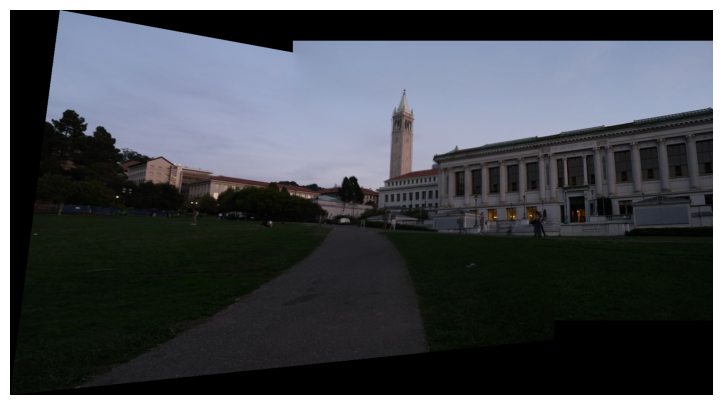

Saving combined image to output/glade.jpg


In [8]:
# Glade
_ = create_panorama("data/glade-1.jpg", "data/glade-2.jpg", "output/glade.jpg")

Processing data/moffit-1.jpg and data/moffit-2.jpg
Reading images
Converting images to grayscale for corner detection
Getting Harris corners for image 1
Getting Harris corners for image 2
Displaying Harris corners on original images


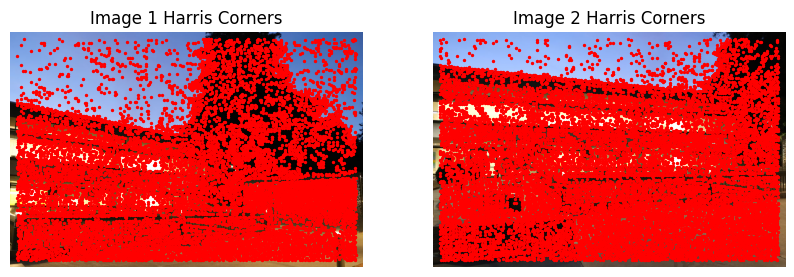

Applying ANMS on image 1


ANMS: 100%|██████████| 11919/11919 [00:01<00:00, 6360.12it/s]


Applying ANMS on image 2


ANMS: 100%|██████████| 13479/13479 [00:03<00:00, 4445.89it/s]


Displaying ANMS corners


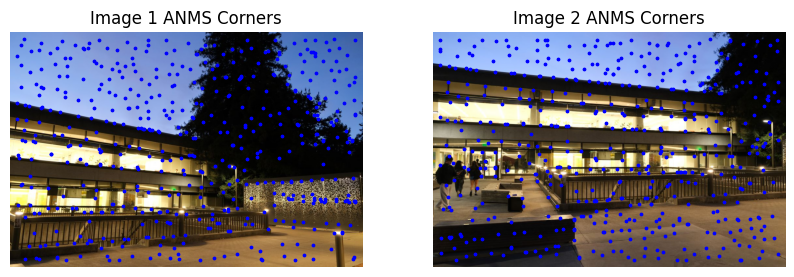

Getting features for image 1
Getting features for image 2
Matching features between images
Visualizing feature pairs


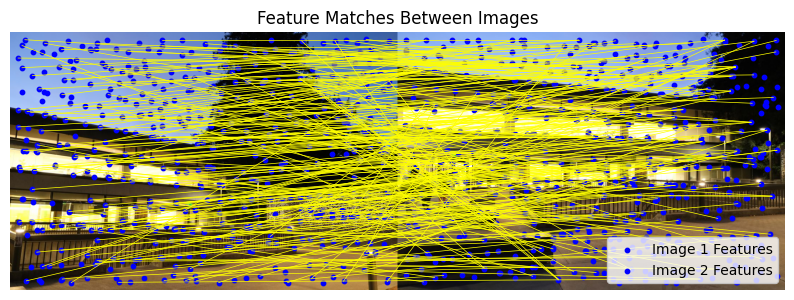

Running RANSAC to compute homography
(500, 2)


RANSAC: 100%|██████████| 3000/3000 [00:27<00:00, 109.08it/s]


Adjusting homography matrix for [x, y, 1] input
Warping image 1
Output image dimensions: width=1685, height=1036
Translation offsets: translate_x=-319.74264173303084, translate_y=389.7862965276849
Starting inverse mapping of pixels...
Combining images into a panorama
Displaying combined image


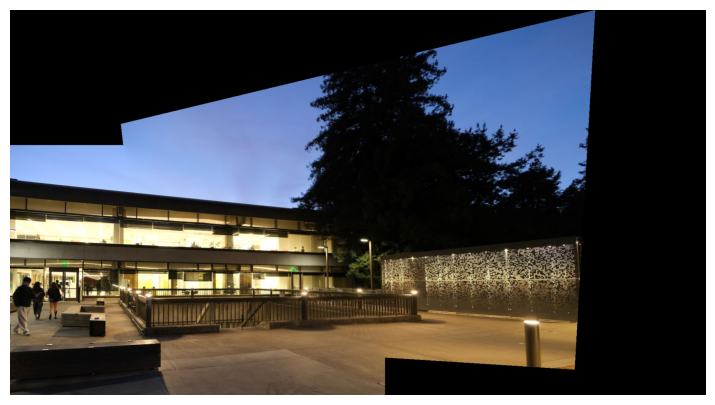

Saving combined image to output/moffit.jpg


In [9]:
# Moffit
_ = create_panorama("data/moffit-1.jpg", "data/moffit-2.jpg", "output/moffit.jpg")

Processing data/sproul-1.jpg and data/sproul-2.jpg
Reading images
Converting images to grayscale for corner detection
Getting Harris corners for image 1
Getting Harris corners for image 2
Displaying Harris corners on original images


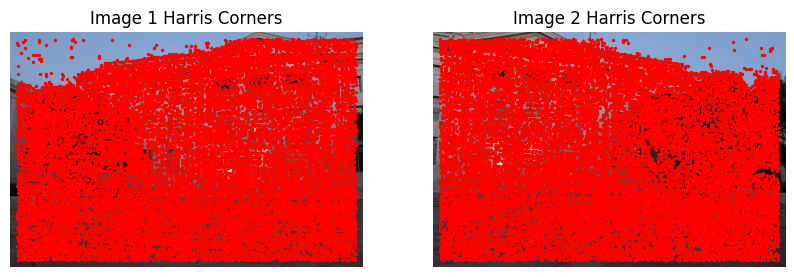

Applying ANMS on image 1


ANMS: 100%|██████████| 15497/15497 [00:02<00:00, 6900.55it/s] 


Applying ANMS on image 2


ANMS: 100%|██████████| 15842/15842 [00:02<00:00, 7911.84it/s] 


Displaying ANMS corners


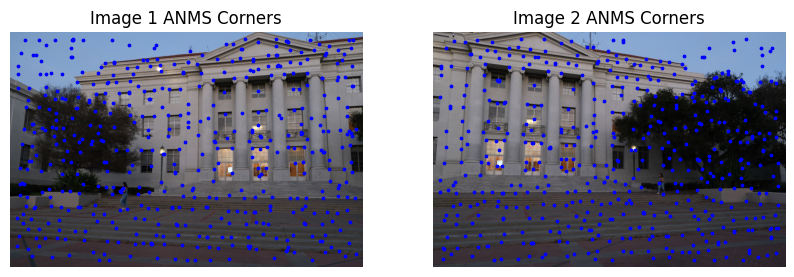

Getting features for image 1
Getting features for image 2
Matching features between images
Visualizing feature pairs


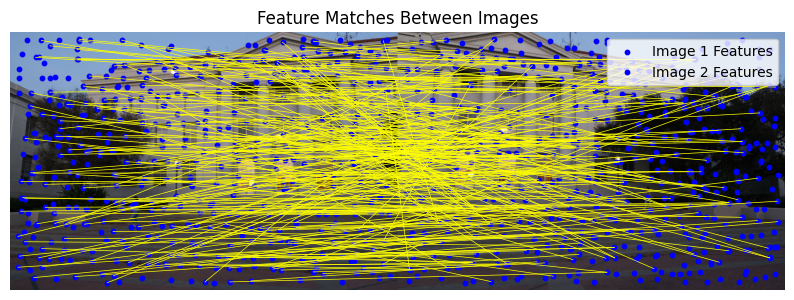

Running RANSAC to compute homography
(500, 2)


RANSAC: 100%|██████████| 3000/3000 [00:19<00:00, 157.85it/s]


Found homography matrix:
[[ 2.58250500e+00  9.01056314e-01 -7.43743052e+02]
 [-7.49820182e-02  3.12643199e+00 -1.58241595e+03]
 [ 8.66453373e-05  1.98578792e-03  1.00000000e+00]]
 with 11 inliers and 13.329138045955915 distance
Adjusting homography matrix for [x, y, 1] input
Warping image 1
Output image dimensions: width=2153, height=1792
Translation offsets: translate_x=1582.4159463224562, translate_y=743.7430522867405
Starting inverse mapping of pixels...
Combining images into a panorama
Displaying combined image


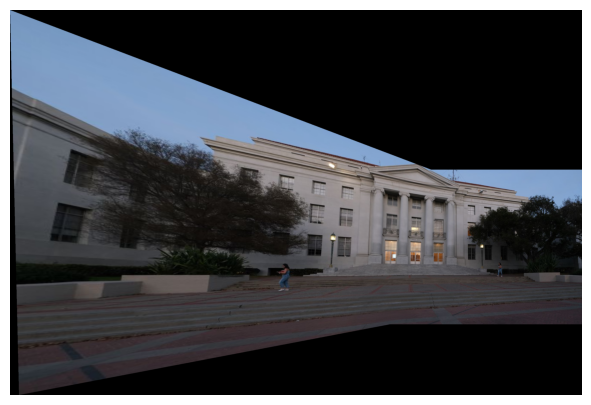

Saving combined image to output/sproul.jpg


In [5]:
# Sproul
_ = create_panorama("data/sproul-1.jpg", "data/sproul-2.jpg", "output/sproul.jpg")